In [2]:
import numpy as np
import os
import random

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image
from read_HiC import name_chromosomes
import seaborn as sns

import sys
path=r'C:\Users\scalvinib\Documents\Phd_project_reduced\work directory jupyter lab\topology\genome_topology\functions'

sys.path.append(path)

from plotting_tools import set_layout
from genome_topology import normalize_psc
from genome_topology import get_matrix
from genome_topology import fractal_dimension
from genome_topology import make_graph
from plotting_tools import save_figures
from matrix_analysis import PlotMatrix_SelectFraction
from matrix_analysis import Select_entangled_fraction
from statistical_analysis import comparison_distributions

from matrix_analysis import write_topology_matrix

## CIRCUIT TOPOLOGY ANALISIS FROM HIC MAPS
Here 4 bulk Hi-C maps are analyzed, two from cells treated with the drug Curaxin, and two controls. 
 - Pick the resolution of the HiC map you want to analyze (in Kb). The various resolution maps were generated with cooler 'zoomify' command.
 - Pick the quantile threshold to select only the most frequent contacts. Picking a threshold that is too low (depending on the resolution) would cause the data to exceed the memory allocated for arrays.

In [3]:
set_layout(18, 18, 18)

## Load data
The data at this point is not combined into one dataframe because handling such a huge dataframe might cause long running time. We only combine the data together after filtering

In [18]:
resolution = '20'
path = 'data/Hi-C data/curaxin/zoomify processed'
samples = ['Control1', 'Control2', 'Treated1', 'Treated2']
control1 = pd.DataFrame()
control2 = pd.DataFrame()
treated1 = pd.DataFrame()
treated2 = pd.DataFrame()

frames = [None]*4

for ind, sample in enumerate(samples):
    df =  pd.read_csv(f'{path}/{sample}{resolution}', sep = '\t', header = None, 
                      names = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'count', 'balanced'],
                     dtype={'chrom1': 'str'})
    
    
    frames[ind] = df.dropna().reset_index(drop=True)
    sample_col = [sample]* len(frames[ind])
    frames[ind]['Sample'] = sample_col
    
    
control1 = frames[0]
control2 = frames[1]
treated1 = frames[2]
treated2 = frames[3]   

chromosomes = control1['chrom1'].unique()
print(chromosomes)

['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' 'X']


## Filter for more frequent contacts.
Choose the quantile threshold, and select whether you want to analyze counts ('count') or balanced counts ('balanced')

In [19]:
count = 'count'
quantile_thresh = 0.99
frames = [control1, control2, treated1, treated2]

contacts = pd.DataFrame()

total_data = list(control1[count]) + list(control2[count]) + list(treated1[count]) + list(treated2[count])
data = {'counts': total_data}
data = pd.DataFrame(data)
threshold = data['counts'].quantile(quantile_thresh)

for frame in frames:
    frame = frame[frame[count]>= threshold]
    frame = pd.DataFrame(frame)
    frames = [contacts, frame]
    contacts = pd.concat(frames)

    
new_index = np.linspace(1, len(contacts), len(contacts), dtype = int)
contacts['Index'] = new_index
contacts = contacts.set_index('Index')

Plot distribution of selected contacts


<AxesSubplot:xlabel='count', ylabel='Count'>

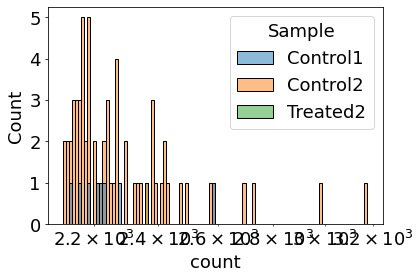

In [7]:
sns.histplot(x = 'count', hue = 'Sample', data = contacts, log_scale = True, bins= 100)

## OPTIONAL: Plot contact distribution + threshold (use only for low resolution) 

Text(0.5, 0, 'Contact count')

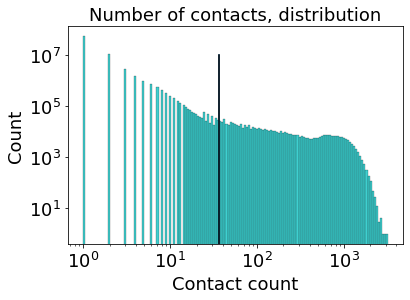

In [8]:
#Make dataframe of all data combined
frames = [control1, control2, treated1, treated2]
df_tot = pd.concat(frames)
new_index = np.linspace(1, len(df_tot), len(df_tot), dtype = int)
df_tot['Index'] = new_index
df_tot = df_tot.set_index('Index')

#Make vertical line for quantile threshold
y1 = np.linspace(0, 10**7, 10)
x1 = np.ones(10)*threshold
plt.plot(x1, y1)

#Plot histogram
sns.histplot( x = 'count', data = df_tot, color = 'c', log_scale = True, bins = 150)
plt.plot(x1, y1, color = 'k')
plt.yscale('log')
plt.title('Number of contacts, distribution')
plt.xlabel('Contact count')

## OPTIONAL: Calculate p values associated to contact distributions for the 4 samples

Control1, Control2
the distributions are not normal: 2.6206690888451006e-35, 8.087053163222677e-36
The distributions have equal variance: 0.16541051687158514
Mannwhitneyu test: False = 0.005523781463222464
Control1, Treated1
the distributions are not normal: 7.468025239397531e-36, 1.7888643471263245e-35
The distributions have equal variance: 0.9181399738317467
Mannwhitneyu test: True = 0.13248919293967085
Control1, Treated2
the distributions are not normal: 1.0641487341133172e-32, 2.5498867539075216e-32
The distributions have equal variance: 0.6307379030056712
Mannwhitneyu test: True = 0.5276249767219305
Control2, Control1
the distributions are not normal: 3.6072282645200743e-35, 1.0533756957300156e-32
The distributions have equal variance: 0.42630956421739974
Mannwhitneyu test: True = 0.5093541776543984
Control2, Treated1
the distributions are not normal: 3.623086819776932e-35, 1.3591768225752897e-34
The distributions have equal variance: 0.16031972625471497
Mannwhitneyu test: True = 

<AxesSubplot:title={'center':'P-VALUES COUNT'}>

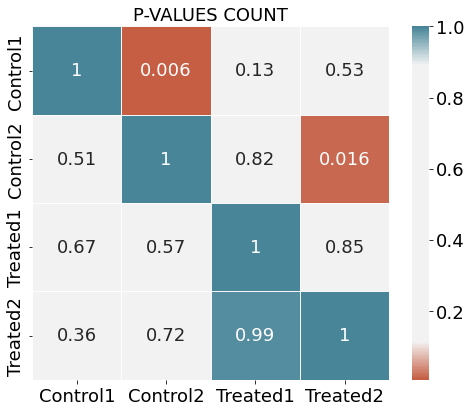

In [9]:
quantity = 'count'

p_values_matrix = np.ones((len(samples), len(samples)))
p_values = {}

for ind1, sample1 in enumerate(samples):
    for ind2, sample2 in enumerate(samples):
        if (sample1 != sample2):
            
            dist1 = df_tot[df_tot['Sample'] == sample1 ][quantity]
            dist2 = df_tot[df_tot['Sample'] == sample2 ][quantity]
            
            sample_1 = random.choices(list(dist1), k=300)
            sample_2 = random.choices(list(dist2), k=300)
            print(f'{sample1}, {sample2}')
            stats = comparison_distributions(sample_1, sample_2)
            p_value = float(stats[-1])
            key = tuple[sample1, sample2]
            p_values[key] = p_value
            p_values_matrix[ind1, ind2] = p_value
            
            
cmap = sns.diverging_palette(220, 20, sep=200, as_cmap=True).reversed()
label = []

a = plt.figure(figsize = (8, 6.5))
plt.title(f'P-values {quantity}'.upper())
sns.heatmap(p_values_matrix, xticklabels = samples, yticklabels = samples, annot = True, cmap = cmap, linewidths=1, 
            linecolor='white', alpha = 0.95)   

# CALCULATE CT AND NETWORK PARAMETERS
Choose path for results and the samples you want to analyze

In [10]:
plot_matrix = 0

In [ ]:
path_df = 'results counts'
selection_sample = 'Control1'
selected_contacts = contacts[contacts['Sample'] == selection_sample]

N_contacts=np.zeros(len(chromosomes))
P=np.zeros(len(chromosomes))
S=np.zeros(len(chromosomes))
X=np.zeros(len(chromosomes))
Dim_fractal = np.zeros(len(chromosomes))
r2_fractalfit = np.zeros(len(chromosomes))
clustering = np.zeros(len(chromosomes))

for t, chrom in enumerate(chromosomes):
    print(chrom)
    contacts_chr= selected_contacts[(selected_contacts['chrom1']== chrom) & (selected_contacts['chrom2']==chrom)]
    
    length1 = (contacts_chr['end1'] -  contacts_chr['start1'])//2
    contacts_chr['position1']=  pd.Series(contacts_chr['start1'] + length1)
    
    length2 = (contacts_chr['end2'] -  contacts_chr['start2'])//2
    contacts_chr['position2']=  pd.Series(contacts_chr['start2'] + length2)
    
    index = [contacts_chr['position1'], contacts_chr['position2']]
    counts = np.array(contacts_chr['count'])
    index=np.array(index)
    index= np.transpose(index)

    N_contacts[t]= len(index)
    
    mat, psc = get_matrix(index, chrom)
    write_topology_matrix(mat, f'{path_df}/matrices', namefile = f'{chrom}_{selection_sample}_{resolution}')
    P[t], S[t], X[t]=normalize_psc(psc, N_contacts[t])
    
    Dim_fractal[t], r2_fractalfit[t] = fractal_dimension(mat, plot_fig=0)
    
    G=make_graph(index)
    clustering[t] = nx.average_clustering(G)
    
    if plot_matrix:
        plt.figure(figsize=(5, 5))
        plt.imshow(mat[:300, :300])
        plt.title('{}'.format(chrom))
    else:
        continue


df = {'Chromosome': chromosomes, 'Parallel (%)': P, 'Series (%)': S, 'Cross (%)': X, 'Clustering coeff': clustering,
      'Fractal dimension': Dim_fractal, 'R2': r2_fractalfit, 'N contacts': N_contacts}
df = pd.DataFrame(df)